# Interpolation by factorized matrix completion

We try to solve the following problem:

$$
arg \;  min_\mathbf{X} \frac{1}{2}||\mathbf{y}-\mathbf{RX}||_2^2 + \mu ||\mathbf{X}||_* = \frac{1}{2}||\mathbf{y}-\mathbf{R\mathbf{U}\mathbf{V}^T}||_2^2 + \mu ||\mathbf{U}\mathbf{V}^T||_*
$$

We use two relaxed versions:

- Regularization with factorized nuclear norm ($||\mathbf{U}\mathbf{V}^T||_*=||\mathbf{U}||_F^2+ ||\mathbf{V}||_F^2$):
$$
arg \;  min_\mathbf{X} \frac{1}{2}||\mathbf{y}-\mathbf{R}(\mathbf{U}\mathbf{V}^T)||_2^2 + \mu ||\mathbf{U}||_F^2+ \mu ||\mathbf{V}||_F^2
$$

- Constrained with factorized nuclear norm ($||\mathbf{U}\mathbf{V}^T||_* \le \frac{1}{2} ||\mathbf{U}, \mathbf{V}||_F^2$):
$$
arg \;  min_\mathbf{X} \frac{1}{2}||\mathbf{y}-\mathbf{R}(\mathbf{U}\mathbf{V}^T)||_2^2 s.t \frac{1}{2} ||\mathbf{U}, \mathbf{V}||_F^2
$$

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.utils.bilinear import LowRankFactorizedMatrix

np.random.seed(0)

In [2]:
# Restriction operator
n, m, k = 200, 100, 10
sub = 0.4
nsub = int(n*m*sub)
iava = np.random.permutation(np.arange(n*m))[:nsub]

Rop = Restriction(n*m, iava)

In [3]:
# model
U = np.random.normal(0., 1., (n, k))
V = np.random.normal(0., 1., (m, k))

X = U @ V.T

# data
y = Rop * X.ravel()

# Masked data
Y = (Rop.H * Rop * X.ravel()).reshape(n, m)

Let's use our function to perform:

- $\mathbf{y}=\mathbf{R}\mathbf{U}\mathbf{V}^T = R_v(\mathbf{u})$
- $\mathbf{y}=\mathbf{R}\mathbf{U}\mathbf{V}^T = R_u(\mathbf{v})$

In [4]:
LOp = LowRankFactorizedMatrix(U, V.T, y, Op=Rop)

y-LOp._matvecx(U.ravel()), y-LOp._matvecy(V.T.ravel())

(array([0., 0., 0., ..., 0., 0., 0.], shape=(8000,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(8000,)))

## Soft constraint
Let's consider the following functional composed of a sum of a smooth term f(x) and a non-smooth one g(x)

$$
arg \;  min_\mathbf{X} f(x)+g(x)
$$

we define the overall model vector $x = [u, v]$, $f=\frac{1}{2}||\mathbf{y}-\mathbf{R}(\mathbf{U}\mathbf{V}^T)||_2^2$  and $g= \mu ||\mathbf{U}||_F^2+ \mu ||\mathbf{V}||_F^2$ (which is the sum of partial elements of x so the proximal is just the vertical stack of their proximals.

Now we can write our iteration as:

$$
x^{k+1} = prox_{\mu\tau^kg} (x^{k} - \tau^k \nabla f)
$$

where $\nabla f = [\nabla f_u, \nabla f_v] = [R_v^T(R_v u^k -y), R_u^T(R_u v^k -y)]$ and the proximal of the Frobenious norm ($prox_g$) is as simple as that of the L2 squared norm of the vector x.

In [5]:
n, m, k = 100, 90, 10
X = np.random.normal(0, 1, (n, k))
Y = np.random.normal(0, 1, (k, m))
X = sp.ndimage.gaussian_filter(X, 1)
Y = sp.ndimage.gaussian_filter(Y, 1)
A = X @ Y

sub = 0.01
nsub = int(n*m*sub)
print(nsub)
iava = np.random.permutation(np.arange(n*m))[:nsub]
Rop = Restriction(n*m, iava)

hop = LowRankFactorizedMatrix(X.copy(), Y.copy(), Rop @ A.ravel(), Rop)

hop.grad(np.hstack([X.ravel(), Y.ravel()]))

90


array([0., 0., 0., ..., 0., 0., 0.], shape=(1900,))

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.utils.bilinear.LowRankFactorizedMatrix'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
tau = 0.005	backtrack = False	beta = 5.000000e-01
epsg = 1.0	niter = 500	tol = None
niterback = 100	acceleration = None

   Itn       x[0]          f           g       J=f+eps*g       tau
     1   3.94690e-01   3.598e+03   2.867e+01   3.627e+03   5.000e-03
     2   4.25043e-01   2.301e+03   2.408e+01   2.325e+03   5.000e-03
     3   4.51052e-01   1.772e+03   2.180e+01   1.794e+03   5.000e-03
     4   4.74041e-01   1.496e+03   2.047e+01   1.517e+03   5.000e-03
     5   4.94613e-01   1.330e+03   1.964e+01   1.350e+03   5.000e-03
     6   5.13258e-01   1.219e+03   1.909e+01   1.238e+03   5.000e-03
     7   5.30388e-01   1.137e+03   1.873e+01   1.156e+03   5.000e-03
     8   5.46338e-01   1.072e+03   1.849e+01   1.090e+03   5.000e-03
     9   5.61367e-01  

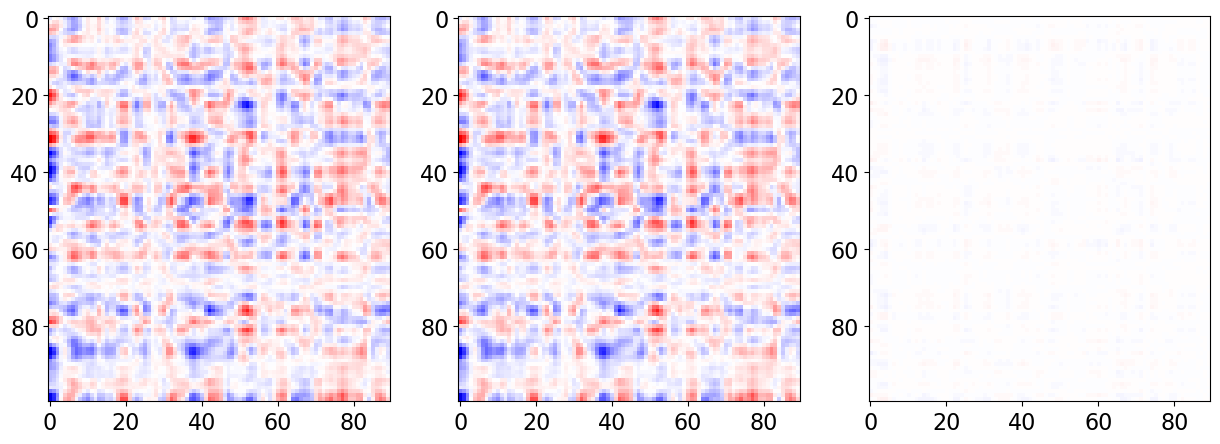

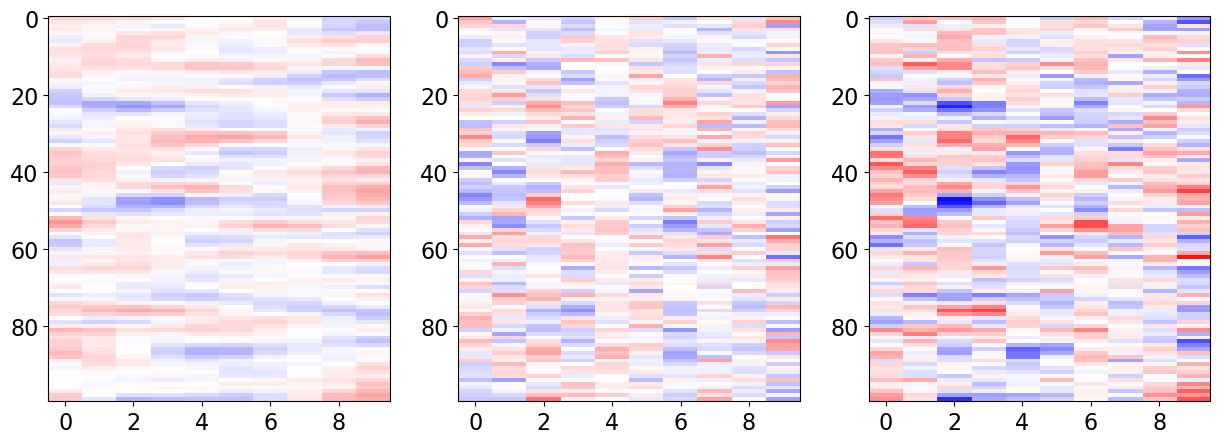

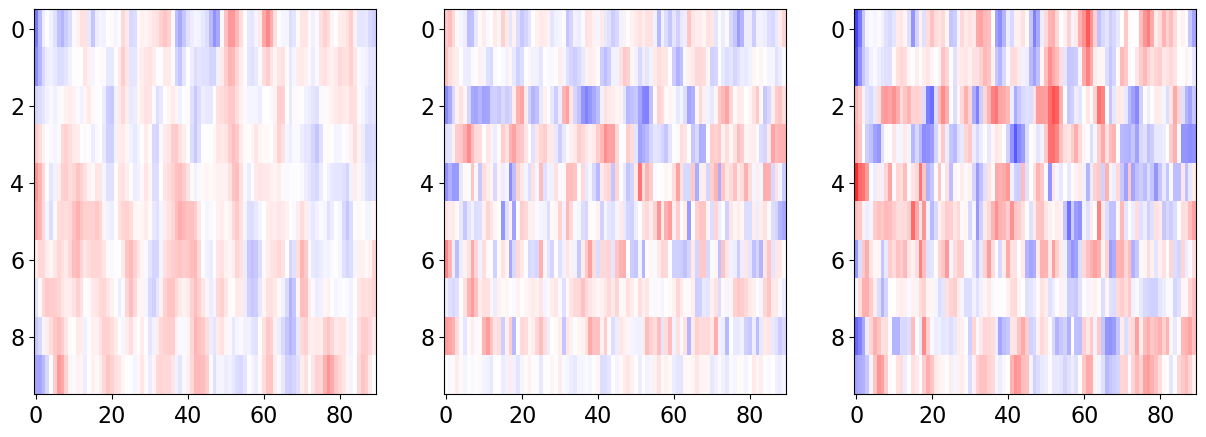

In [6]:
# easy, close to X and Y
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

sigma = 0.1
hop = LowRankFactorizedMatrix(Xin.copy(), Yin.copy(), A.ravel())
l2 = VStack((L2(sigma=sigma), L2(sigma=sigma)), nn=(n*k, k*m))

xest = ProximalGradient(hop, l2, x0=np.hstack([Xin.ravel(), Yin.ravel()]), 
                        tau=5e-3, niter=500, show=True)

Xest, Yest = xest[:n*k].reshape(n, k), xest[n*k:].reshape(k, m)
Aest = Xest @ Yest

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(A, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Aest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(A-Aest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(X, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Xest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(X-Xest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Y, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Yest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(Y-Yest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

## Hard constraint

Let's consider the following functional composed of a sum of a smooth term f(x) and a non-smooth one g(x)

$$
arg \;  min_x f(x) s.t. g(x)<\sigma
$$

we define the overall model vector $x = [u, v]$, $f=\frac{1}{2}||\mathbf{y}-\mathbf{R}(\mathbf{U}\mathbf{V}^T)||_2^2$  and $g= ||\mathbf{U}\mathbf{V}^T||_* \le \frac{1}{2} ||\mathbf{U}, \mathbf{V}||_F^2 = \Phi(\mathbf{U}, \mathbf{V})$ 

Here the proximal is obtained by multiplying each matrix by $\sqrt{\frac{\tau}{\Phi(\mathbf{U}, \mathbf{V})}}$

In [7]:
from pyproximal.ProxOperator import _check_tau
from pyproximal import ProxOperator

class FrobeniousFactorized(ProxOperator):

    def __init__(self, n, m, k, sigma):
        super().__init__(None, False)
        self.n, self.m, self.k = n, m, k
        self.sigma = sigma
        
    def __call__(self, x):
        L, R = x[:self.n*self.k].reshape(self.n, self.k), x[self.n*self.k:].reshape(self.k, self.m)
        return 0.5 * np.linalg.norm(np.vstack([L, R.T]), ord='fro') ** 2

    @_check_tau
    def prox(self, x, tau):
        L, R = x[:self.n*self.k].reshape(self.n, self.k), x[self.n*self.k:].reshape(self.k, self.m)
        scale = np.sqrt(self.sigma / self(x))
        L, R = scale * L, scale * R
        x = np.hstack([L.ravel(), R.ravel()])
        return x

In [8]:
# easy, close to X and Y
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

fb = FrobeniousFactorized(n, m, k, sigma=5.)

xx = np.hstack([Xin.ravel(), Yin.ravel()])
print(fb(xx))
yy = fb.prox(xx, 1.) # tau is irrelevant
print(fb(yy))

960.0338638954306
4.999999999999998


Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.utils.bilinear.LowRankFactorizedMatrix'>
Proximal operator (g): <class '__main__.FrobeniousFactorized'>
tau = 0.005	backtrack = False	beta = 5.000000e-01
epsg = 1.0	niter = 500	tol = None
niterback = 100	acceleration = None

   Itn       x[0]          f           g       J=f+eps*g       tau
     1   6.78771e-01   1.456e+03   1.010e+02   1.557e+03   5.000e-03
     2   6.81186e-01   1.402e+03   1.010e+02   1.503e+03   5.000e-03
     3   6.80835e-01   1.348e+03   1.010e+02   1.449e+03   5.000e-03
     4   6.77899e-01   1.293e+03   1.010e+02   1.394e+03   5.000e-03
     5   6.72567e-01   1.237e+03   1.010e+02   1.338e+03   5.000e-03
     6   6.65031e-01   1.181e+03   1.010e+02   1.282e+03   5.000e-03
     7   6.55481e-01   1.123e+03   1.010e+02   1.224e+03   5.000e-03
     8   6.44109e-01   1.064e+03   1.010e+02   1.165e+03   5.000e-03
     9   6.31111e-01   1.0

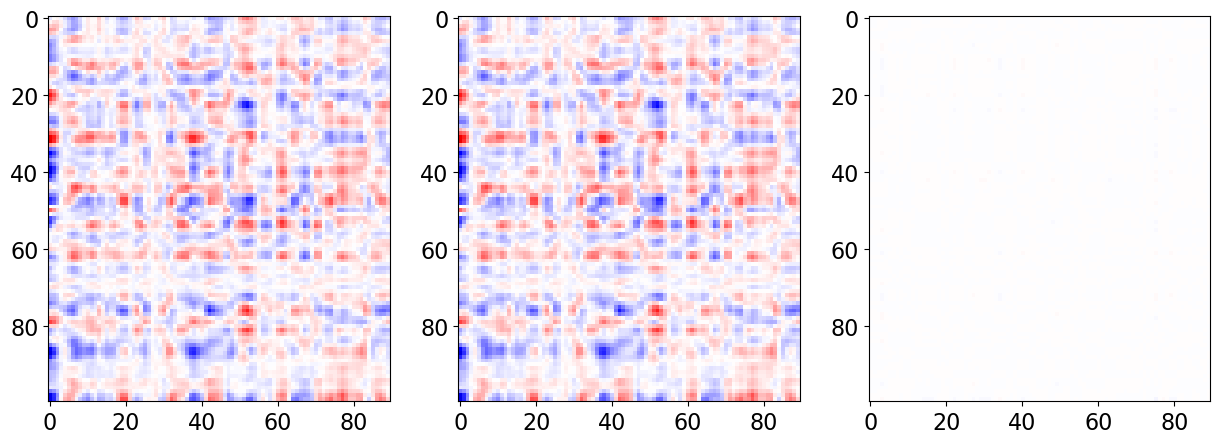

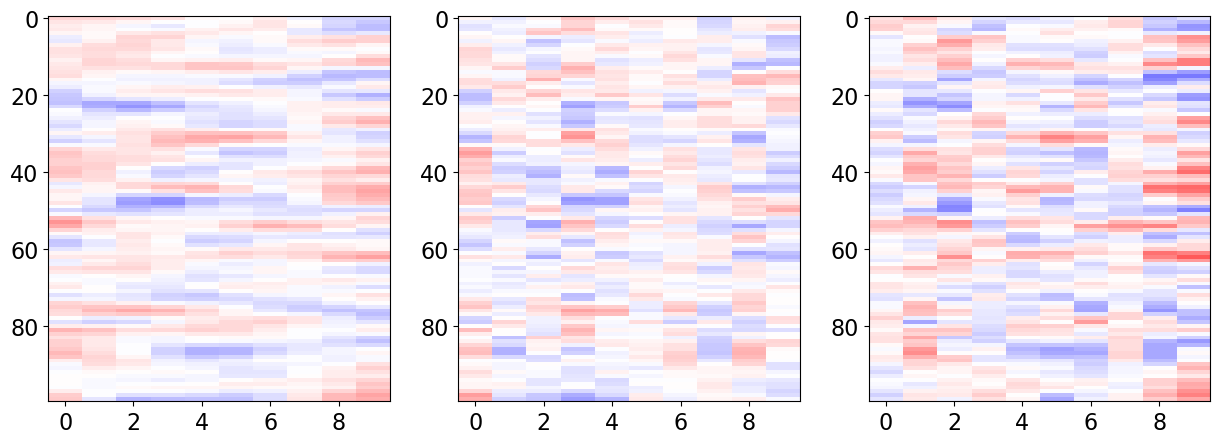

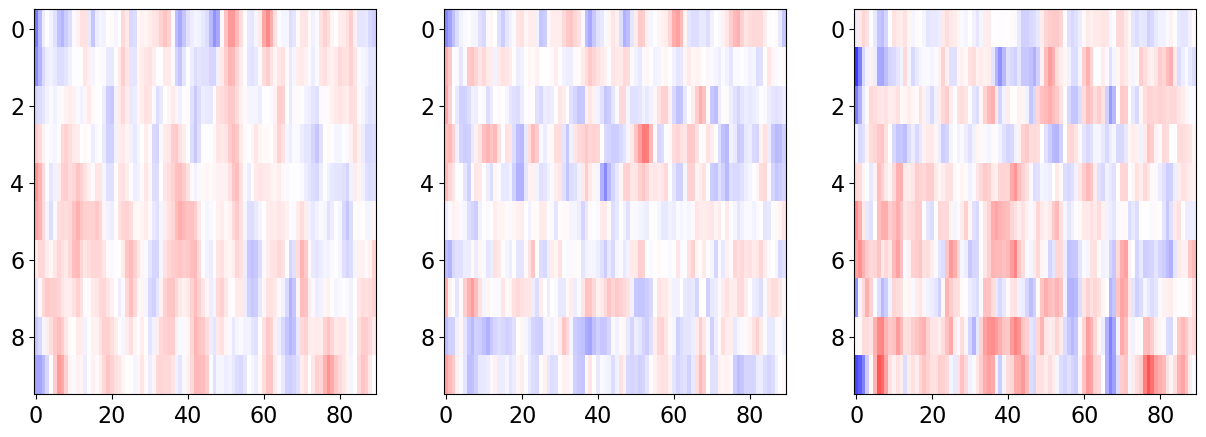

In [9]:
# easy, close to X and Y
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

hop = LowRankFactorizedMatrix(Xin.copy(), Yin.copy(), A.ravel())
fb = FrobeniousFactorized(n, m, k, sigma=fb(np.hstack([X.ravel(), Y.ravel()])))

xest = ProximalGradient(hop, fb, x0=np.hstack([Xin.ravel(), Yin.ravel()]), 
                        tau=5e-3, niter=500, show=True)

Xest, Yest = xest[:n*k].reshape(n, k), xest[n*k:].reshape(k, m)
Aest = Xest @ Yest

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(A, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Aest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(A-Aest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(X, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Xest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(X-Xest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Y, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Yest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(Y-Yest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');